In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Read in Data

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

# read in data 
data = pd.read_csv(r".\Data Carrard et al. 2022 MedTeach.csv")
    
data_info = pd.read_csv(r".\Codebook Carrard et al. 2022 MedTeach.csv", sep=";")
display(data_info.head(21)[["Variable Name", "Variable Label", "Variable Scale"]])

,Variable Name,Variable Label,Variable Scale
0,id,Participants ID number,string
1,age,age at questionnaire 20-21,numeric
2,year,CURICULUM YEAR : In which curriculum year are ...,1=Bmed1; 2=Bmed2; 3=Bmed3; 4=Mmed1; 5=Mmed2; 6...
3,sex,GENDER : To which gender do you identify the m...,1=Man; 2=Woman; 3=Non-binary
4,glang,MOTHER TONGUE: What is your mother tongue?,1=French; 15=German; 20=English; 37=Arab; 51=B...
5,part,PARTNERSHIP STATUS : Do you have a partner?,0=No; 1=Yes
6,job,HAVING A JOB : Do you have a paid job?,0=No; 1=Yes
7,stud_h,"HOURS OF STUDY PER WEEK : On average, how many...",NaN
8,health,SATISFACTION WITH HEALTH : How satisfied are y...,1=Verydissatisfied; 2=Dissatisfied; 3=Neithers...
9,psyt,PSYCHOTHERAPY LAST YEAR : During the last 12 m...,0=No; 1=Yes


### Visualize Burnout Metric Distribution

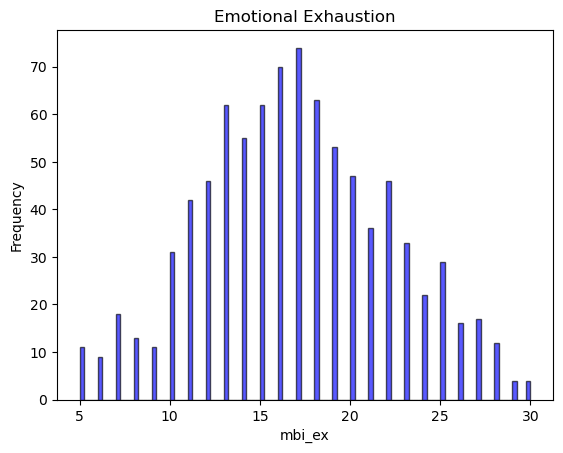

count    886.000000
mean      16.878104
std        5.256025
min        5.000000
25%       13.000000
50%       17.000000
75%       20.000000
max       30.000000
Name: mbi_ex, dtype: float64


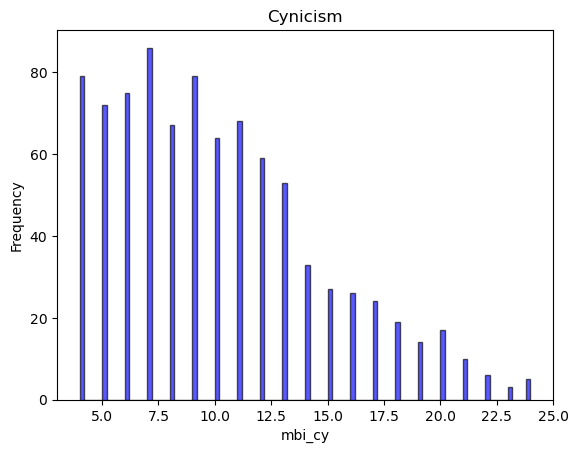

count    886.000000
mean      10.079007
std        4.592609
min        4.000000
25%        6.000000
50%        9.000000
75%       13.000000
max       24.000000
Name: mbi_cy, dtype: float64


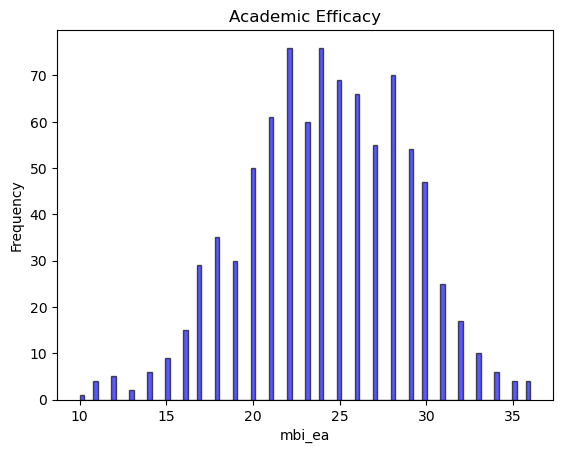

count    886.000000
mean      24.207675
std        4.633675
min       10.000000
25%       21.000000
50%       24.000000
75%       28.000000
max       36.000000
Name: mbi_ea, dtype: float64


In [37]:
#plot histogram of data, mbi_ex
plt.hist(data['mbi_ex'], bins=100, color='blue', edgecolor='black', alpha=0.65)
plt.xlabel('mbi_ex')
plt.ylabel('Frequency')
plt.title('Emotional Exhaustion')
plt.show()
print(data['mbi_ex'].describe())

plt.hist(data['mbi_cy'], bins=100, color='blue', edgecolor='black', alpha=0.65)
plt.xlabel('mbi_cy')
plt.ylabel('Frequency')
plt.title('Cynicism')
plt.show()
print(data['mbi_cy'].describe())

plt.hist(data['mbi_ea'], bins=100, color='blue', edgecolor='black', alpha=0.65)
plt.xlabel('mbi_ea')
plt.ylabel('Frequency')
plt.title('Academic Efficacy')
plt.show()
print(data['mbi_ea'].describe())



## Data Preprocessing

Here we set certain parameters to be more easily classified. 

In [38]:
#set 'sex' to 0 or 1
data['sex'] = data['sex'] - 1

#set 'mbi_ex' to 0 if below 19, 1 if above
data['mbi_ex'] = np.where(data['mbi_ex'] < 19, 0, 1)

#set 'mbi_cy' to 0 if below 11, 1 if above
data['mbi_cy'] = np.where(data['mbi_cy'] < 11, 0, 1)

#set 'mbi_ea' to 0 if above 22, 1 if below
data['mbi_ea'] = np.where(data['mbi_ea'] > 22, 0, 1)

#set 'glang' to 0 if not already 1
data['glang'] = np.where(data['glang'] > 1, 0, data['glang'])

#split half of the data randomly into training and validation sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(data, data["mbi_ex"]):
    train = data.loc[train_index]
    val = data.loc[val_index]


# Dataframe to hold results on performance of models

results = pd.DataFrame(columns=['Model', 'Metric Predicted', 'Accuracy', 'roc_auc_score', 'f1_score', 'precision_score', 'recall_score', 'hyperparameters'])

### Predicting Burnout:

It is important to note that these values for burnout were collected as a result of psychological surveys. If this were to be used in some automated fashion, then it would have to draw conclusions on data which would be accessable, but not in the form of a survey.

For the sake of this use case, its assumed that the following are known:

- age
- year
- sex
- mother tongue
- partnership status
- job status
- hours of study per week
- satisfaction with health
- was psychotherapy had in the last year

In [39]:
from sklearn import ensemble

y_ex_train = train['mbi_ex']
y_cy_train = train['mbi_cy']
y_ea_train = train['mbi_ea']
y_ex_val = val['mbi_ex']
y_cy_val = val['mbi_cy']
y_ea_val = val['mbi_ea']
val_X = val[['age', 'year', 'sex', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]
train_X = train[['age', 'year', 'sex', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]


## Fitting Random Forest
##### Using Random Forest to predict burnout values

In [40]:
#using random forest classifier to predict burnout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score


n_estimators = [10, 100, 200, 1000]
max_depth = [2, 5, 20, 100, None]

# Exhaustion
max_performance = 0
best_forest_model_cy_ex = None
for n in n_estimators:
    for depth in max_depth:
        
        forest_model = RandomForestClassifier(n_estimators=n, random_state=0, max_depth=depth)
        forest_model.fit(train_X, y_ex_train)

        # performance = forest_model.score(val_X, y_ex_val)
        performance = roc_auc_score(y_ex_val, forest_model.predict(val_X))

        if performance > max_performance:
            best_n = n
            best_depth = depth
            max_performance = performance
            best_forest_model_ex = forest_model

print("Forest Model - Classifier, Exhaustion")
print("Best n_estimators:", best_n)
print("Best max_depth:", best_depth)
print("Training score:", best_forest_model_ex.score(train_X, y_ex_train))
print("Validation score:", best_forest_model_ex.score(val_X, y_ex_val))

results = results.append({\
'Model': 'Forest Model - Classifier, Exhaustion',
'Accuracy': best_forest_model_ex.score(val_X, y_ex_val),
'Metric Predicted': 'Exhaustion',
'roc_auc_score': roc_auc_score(y_ex_val, best_forest_model_ex.predict(val_X)),
'f1_score': f1_score(y_ex_val, best_forest_model_ex.predict(val_X)),
'precision_score': precision_score(y_ex_val, best_forest_model_ex.predict(val_X)),
'recall_score': recall_score(y_ex_val, best_forest_model_ex.predict(val_X)),
'hyperparameters': 'n_estimators: ' + str(best_n) + ', max_depth: ' + str(best_depth)
  }, ignore_index=True)

# Cynicism
max_performance = 0
best_forest_model_cy = None
for n in n_estimators:
    for depth in max_depth:

        forest_model = RandomForestClassifier(n_estimators=n, random_state=0, max_depth=depth)
        forest_model.fit(train_X, y_cy_train)
        # performance = forest_model.score(val_X, y_cy_val)
        performance = roc_auc_score(y_cy_val, forest_model.predict(val_X))
        
        if performance > max_performance:
            best_n = n
            best_depth = depth
            max_performance = performance
            best_forest_model_cy = forest_model

print("Forest Model - Classifier, Cynicism")
print("Best n_estimators:", best_n)
print("Best max_depth:", best_depth)
print("Training score:", best_forest_model_cy.score(train_X, y_cy_train))
print("Validation score:", best_forest_model_cy.score(val_X, y_cy_val))
results = results.append({
    'Model': 'Forest Model - Classifier, Cynicism', 'Accuracy': best_forest_model_cy.score(val_X, y_cy_val),
    'Metric Predicted': 'Cynicism',
    'roc_auc_score': roc_auc_score(y_cy_val, best_forest_model_cy.predict(val_X)),
    'f1_score': f1_score(y_cy_val, best_forest_model_cy.predict(val_X)),
    'precision_score': precision_score(y_cy_val, best_forest_model_cy.predict(val_X)),
    'recall_score': recall_score(y_cy_val, best_forest_model_cy.predict(val_X)),
    'hyperparameters': 'n_estimators: ' + str(best_n) + ', max_depth: ' + str(best_depth)
}, ignore_index=True)


# Academic Efficacy
max_performance = 0
best_forest_model_ea = None
for n in n_estimators:
    for depth in max_depth:
        
        forest_model = RandomForestClassifier(n_estimators=n, random_state=0, max_depth=depth)
        forest_model.fit(train_X, y_ea_train)

        # performance = forest_model.score(val_X, y_ea_val)
        performance = roc_auc_score(y_ea_val, forest_model.predict(val_X))
        if performance > max_performance:
            best_n = n
            best_depth = depth
            max_performance = performance
            best_forest_model_ea = forest_model

print("Forest Model - Classifier, Cynicism")
print("Best n_estimators:", best_n)
print("Best max_depth:", best_depth)
print("Training score:", best_forest_model_ea.score(train_X, y_ea_train))
print("Validation score:", best_forest_model_ea.score(val_X, y_ea_val))

results = results.append(
    {'Model': 'Forest Model - Academic Efficacy',
    'Accuracy': best_forest_model_ea.score(val_X, y_ea_val),
    'Metric Predicted': 'Academic Efficacy',
    'roc_auc_score': roc_auc_score(y_ea_val, best_forest_model_ea.predict(val_X)),
    'f1_score': f1_score(y_ea_val, best_forest_model_ea.predict(val_X)),
    'precision_score': precision_score(y_ea_val, best_forest_model_ea.predict(val_X)),
    'recall_score': recall_score(y_ea_val, best_forest_model_ea.predict(val_X)),
    'hyperparameters': 'n_estimators: ' + str(best_n) + ', max_depth: ' + str(best_depth)
    }, ignore_index=True)

display(results)


Forest Model - Classifier, Exhaustion
Best n_estimators: 200
Best max_depth: 5
Training score: 0.7429378531073446
Validation score: 0.6685393258426966


C:\Users\orion\AppData\Local\Temp\ipykernel_17628\190857271.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({\


Forest Model - Classifier, Cynicism
Best n_estimators: 200
Best max_depth: 20
Training score: 0.9887005649717514
Validation score: 0.6235955056179775


C:\Users\orion\AppData\Local\Temp\ipykernel_17628\190857271.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


Forest Model - Classifier, Cynicism
Best n_estimators: 200
Best max_depth: 20
Training score: 0.9929378531073446
Validation score: 0.6123595505617978


C:\Users\orion\AppData\Local\Temp\ipykernel_17628\190857271.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


,Model,Metric Predicted,Accuracy,roc_auc_score,f1_score,precision_score,recall_score,hyperparameters
0,"Forest Model - Classifier, Exhaustion",Exhaustion,0.668539,0.593887,0.415842,0.567568,0.328125,"n_estimators: 200, max_depth: 5"
1,"Forest Model - Classifier, Cynicism",Cynicism,0.623596,0.590177,0.464000,0.568627,0.391892,"n_estimators: 200, max_depth: 20"
2,Forest Model - Academic Efficacy,Academic Efficacy,0.612360,0.572065,0.429752,0.530612,0.361111,"n_estimators: 200, max_depth: 20"


##### Evaluating Random Forest

In [41]:
# Display Feature importances for exhaustion

importances = best_forest_model_ex.feature_importances_
forest_params = np.argsort(importances)[::-1]
forest_top_features_ex = []
for i in range(9):
    forest_top_features_ex.append(train_X.columns[forest_params[i]])
forest_top_features_ex_str = []
for f in range(9):
    forest_top_features_ex_str.append("%d. %s (%f)" % (f + 1, forest_top_features_ex[f], importances[forest_params[f]]))


# Display Feature importances for cynicism

importances = best_forest_model_cy.feature_importances_
forest_params = np.argsort(importances)[::-1]
forest_top_features_cy = []
for i in range(9):
    forest_top_features_cy.append(train_X.columns[forest_params[i]])
forest_top_features_cy_str = []
for f in range(9):
    forest_top_features_cy_str.append("%d. %s (%f)" % (f + 1, forest_top_features_cy[f], importances[forest_params[f]]))


# Display Feature importances for academic efficacy

importances = best_forest_model_ea.feature_importances_
forest_params = np.argsort(importances)[::-1]
forest_top_features_ea = []
for i in range(9):
    forest_top_features_ea.append(train_X.columns[forest_params[i]])
forest_top_features_ea_str = []
for f in range(9):
    forest_top_features_ea_str.append("%d. %s (%f)" % (f + 1, forest_top_features_ea[f], importances[forest_params[f]]))

# #Place in pandas dataframe
forest_top_features = pd.DataFrame({
    'Exhaustion': forest_top_features_ex_str,
    'Cynicism': forest_top_features_cy_str,
    'Academic Efficacy': forest_top_features_ea_str,
    })

# #Display results
print("Forest Model - Top 9 Features")
display(forest_top_features)


Forest Model - Top 9 Features


,Exhaustion,Cynicism,Academic Efficacy
0,1. health (0.289805),1. stud_h (0.345157),1. stud_h (0.320979)
1,2. stud_h (0.246232),2. age (0.200337),2. age (0.188388)
2,3. year (0.160559),3. year (0.120707),3. health (0.127234)
3,4. age (0.131663),4. health (0.107285),4. year (0.123802)
4,5. sex (0.052235),5. part (0.051910),5. sex (0.054504)
5,6. psyt (0.047928),6. sex (0.047728),6. part (0.052580)
6,7. glang (0.026918),7. job (0.047046),7. job (0.051817)
7,8. part (0.023702),8. psyt (0.040411),8. psyt (0.043060)
8,9. job (0.020958),9. glang (0.039420),9. glang (0.037635)


## Fitting Neural Net
##### Using Neural Net to predict burnout values

Neural Network - Exhaustion
6/6 [==============================] - 0s 1ms/step
Best Epochs: 50
Best Nodes: 5
23/23 [==============================] - 0s 2ms/step - loss: 0.6040 - accuracy: 0.6766
Training score: 0.6765536665916443
6/6 [==============================] - 0s 2ms/step - loss: 0.6002 - accuracy: 0.7135
Validation score: 0.7134831547737122
6/6 [==============================] - 0s 2ms/step
roc_auc_score: 0.6894188596491228


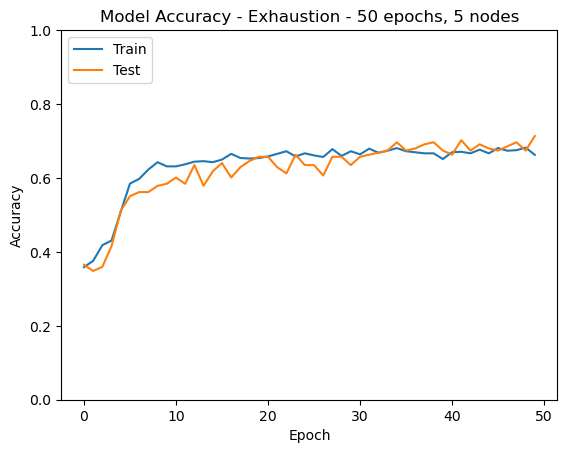

6/6 [==============================] - 0s 2ms/step
Neural Network - Cynicism


C:\Users\orion\AppData\Local\Temp\ipykernel_17628\1668393539.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


6/6 [==============================] - 0s 2ms/step
Best Epochs: 25
Best Nodes: 10
23/23 [==============================] - 0s 2ms/step - loss: 0.6611 - accuracy: 0.6088
Training score: 0.6087570786476135
6/6 [==============================] - 0s 2ms/step - loss: 0.6570 - accuracy: 0.6517
Validation score: 0.6516854166984558
6/6 [==============================] - 0s 2ms/step
roc_auc_score: 0.6235706860706861


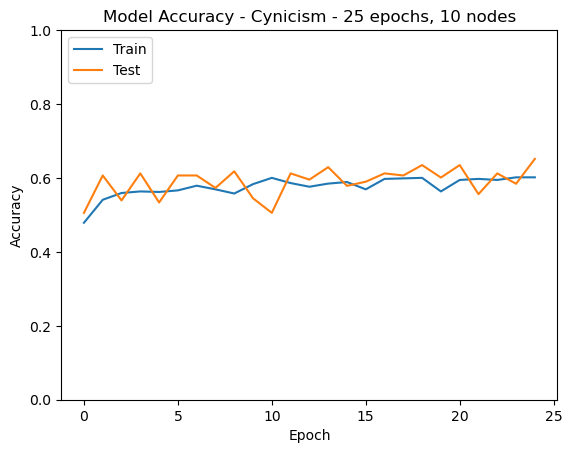

6/6 [==============================] - 0s 2ms/step
Neural Network - Academic Efficacy


C:\Users\orion\AppData\Local\Temp\ipykernel_17628\1668393539.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


6/6 [==============================] - 0s 1ms/step
Best Epochs: 25
Best Nodes: 8
23/23 [==============================] - 0s 2ms/step - loss: 0.6194 - accuracy: 0.6511
Training score: 0.651129961013794
6/6 [==============================] - 0s 2ms/step - loss: 0.6699 - accuracy: 0.5955
Validation score: 0.5955055952072144
6/6 [==============================] - 0s 2ms/step
roc_auc_score: 0.6257861635220126


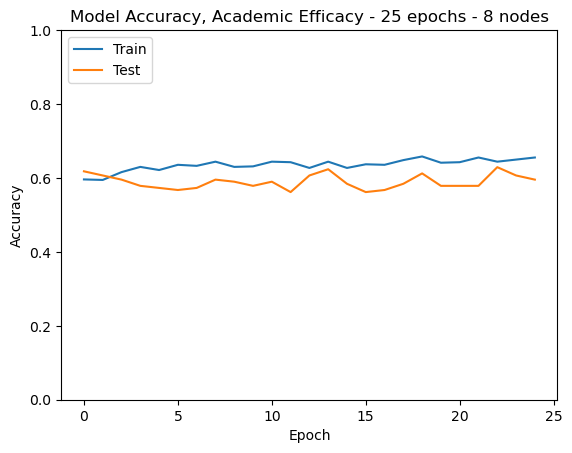

6/6 [==============================] - 0s 1ms/step


C:\Users\orion\AppData\Local\Temp\ipykernel_17628\1668393539.py:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
tf.random.set_seed(42)

epoch_nums = [25, 50]
node_nums = [5, 8, 10]

# Exhaustion
print("Neural Network - Exhaustion")

best_model = None
best_accuracy = 0
best_epoch = 0
best_node = 0
for epoch in epoch_nums:
    for node in node_nums:
    
        model = Sequential()
        model.add(Dense(node, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, y_ex_train, epochs=epoch, batch_size=10, verbose=0, validation_data=(val_X, y_ex_val))
        # performance = model.evaluate(val_X, y_ex_val)[1]
        performance = roc_auc_score(y_ex_val, model.predict(val_X).round())
        if best_accuracy < performance:
            best_model = model
            best_accuracy = performance
            best_epoch = epoch
            best_node = node
            best_history = history

print("Best Epochs:", best_epoch)
print("Best Nodes:", best_node)
print("Training score:", best_model.evaluate(train_X, y_ex_train)[1])
print("Validation score:", best_model.evaluate(val_X, y_ex_val)[1])
print('roc_auc_score:', roc_auc_score(y_ex_val, best_model.predict(val_X)))
# plot best history
# plot training and test accuracy
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title(f'Model Accuracy - Exhaustion - {best_epoch} epochs, {best_node} nodes')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# update axis limits
plt.ylim(0, 1)
plt.show()



results = results.append({
    'Model': 'Neural Network - Exhaustion', 
    'Accuracy': best_model.evaluate(val_X, y_ex_val)[1], 
    'Metric Predicted': 'Exhaustion',
    'roc_auc_score': roc_auc_score(y_ex_val, best_model.predict(val_X).round()),
    'f1_score': f1_score(y_ex_val, best_model.predict(val_X).round()),
    'precision_score': precision_score(y_ex_val, best_model.predict(val_X).round()),
    'recall_score': recall_score(y_ex_val, best_model.predict(val_X).round()),
    'hyperparameters': 'epochs: ' + str(best_epoch) + ', nodes: ' + str(best_node)
    }, ignore_index=True)

# Cynicism

print("Neural Network - Cynicism")

best_model = None
best_accuracy = 0
best_epoch = 0
best_node = 0
for epoch in epoch_nums:
    for node in node_nums:
    
        model = Sequential()
        model.add(Dense(node, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, y_cy_train, epochs=epoch, batch_size=10, verbose=0, validation_data=(val_X, y_cy_val))

        performance = roc_auc_score(y_cy_val, model.predict(val_X).round())
        if best_accuracy < performance:
            best_model = model
            best_accuracy = performance
            best_epoch = epoch
            best_node = node
            best_history = history


print("Best Epochs:", best_epoch)
print("Best Nodes:", best_node)
print("Training score:", best_model.evaluate(train_X, y_cy_train)[1])
print("Validation score:", best_model.evaluate(val_X, y_cy_val)[1])
print('roc_auc_score:', roc_auc_score(y_cy_val, best_model.predict(val_X)))
# plot best history
# plot training and test accuracy
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title(f'Model Accuracy - Cynicism - {best_epoch} epochs, {best_node} nodes')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0, 1)
plt.show()

results = results.append({
    'Model': 'Neural Network - Cynicism', 
    'Accuracy': best_model.evaluate(val_X, y_cy_val)[1], 
    'Metric Predicted': 'Cynicism', 
    'roc_auc_score': roc_auc_score(y_cy_val, best_model.predict(val_X).round()),
    'f1_score': f1_score(y_cy_val, best_model.predict(val_X).round()),
    'precision_score': precision_score(y_cy_val, best_model.predict(val_X).round()),
    'recall_score': recall_score(y_cy_val, best_model.predict(val_X).round()),
    'hyperparameters': 'epochs: ' + str(best_epoch) + ', nodes: ' + str(best_node)
    }, ignore_index=True)

# Academic Efficacy

print("Neural Network - Academic Efficacy")

best_model = None
best_accuracy = 0
best_epoch = 0
best_node = 0

for epoch in epoch_nums:
    for node in node_nums:
    
        model = Sequential()
        model.add(Dense(node, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, y_ea_train, epochs=epoch, batch_size=10, verbose=0, validation_data=(val_X, y_ea_val))
        
        performance = roc_auc_score(y_ea_val, model.predict(val_X).round())
        if best_accuracy < performance:
            best_model = model
            best_accuracy = performance
            best_epoch = epoch
            best_node = node
            best_history = history

print("Best Epochs:", best_epoch)
print("Best Nodes:", best_node)
print("Training score:", best_model.evaluate(train_X, y_ea_train)[1])
print("Validation score:", best_model.evaluate(val_X, y_ea_val)[1])
print('roc_auc_score:', roc_auc_score(y_ea_val, best_model.predict(val_X)))
# plot best history
# plot training and test accuracy
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title(f'Model Accuracy, Academic Efficacy - {best_epoch} epochs - {best_node} nodes')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0, 1)
plt.show()

results = results.append({
    'Model': 'Neural Network - Academic Efficacy', 
    'Accuracy': best_model.evaluate(val_X, y_ea_val)[1], 
    'Metric Predicted': 'Academic Efficacy',
    'roc_auc_score': roc_auc_score(y_ea_val, best_model.predict(val_X).round()),
    'f1_score': f1_score(y_ea_val, best_model.predict(val_X).round()),
    'precision_score': precision_score(y_ea_val, best_model.predict(val_X).round()),
    'recall_score': recall_score(y_ea_val, best_model.predict(val_X).round()),
    'hyperparameters': 'epochs: ' + str(best_epoch) + ', nodes: ' + str(best_node)
    }, ignore_index=True)


#### Evaluating Neural Net

## Evaluating Different Models
##### Breaking down and comparing different model performance, performance table shown.

,Model,Metric Predicted,Accuracy,roc_auc_score,f1_score,precision_score,recall_score,hyperparameters
0,"Forest Model - Classifier, Exhaustion",Exhaustion,0.668539,0.593887,0.415842,0.567568,0.328125,"n_estimators: 200, max_depth: 5"
1,"Forest Model - Classifier, Cynicism",Cynicism,0.623596,0.590177,0.464000,0.568627,0.391892,"n_estimators: 200, max_depth: 20"
2,Forest Model - Academic Efficacy,Academic Efficacy,0.612360,0.572065,0.429752,0.530612,0.361111,"n_estimators: 200, max_depth: 20"
3,Neural Network - Exhaustion,Exhaustion,0.713483,0.622122,0.426966,0.760000,0.296875,"epochs: 50, nodes: 5"
4,Neural Network - Cynicism,Cynicism,0.651685,0.596674,0.392157,0.714286,0.270270,"epochs: 25, nodes: 10"
5,Neural Network - Academic Efficacy,Academic Efficacy,0.595506,0.562369,0.437500,0.500000,0.388889,"epochs: 25, nodes: 8"


<Axes: title={'center': 'f1_score by Model and Metric Predicted'}, ylabel='Model'>

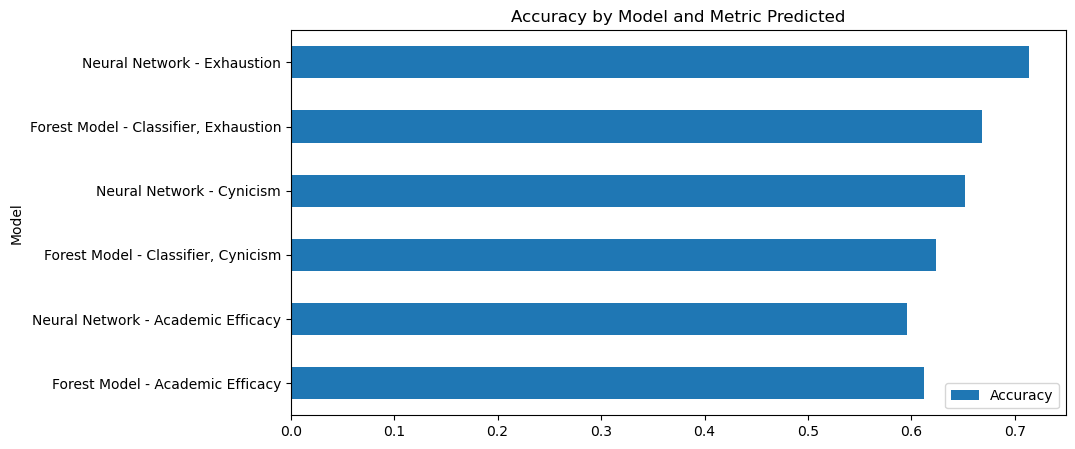

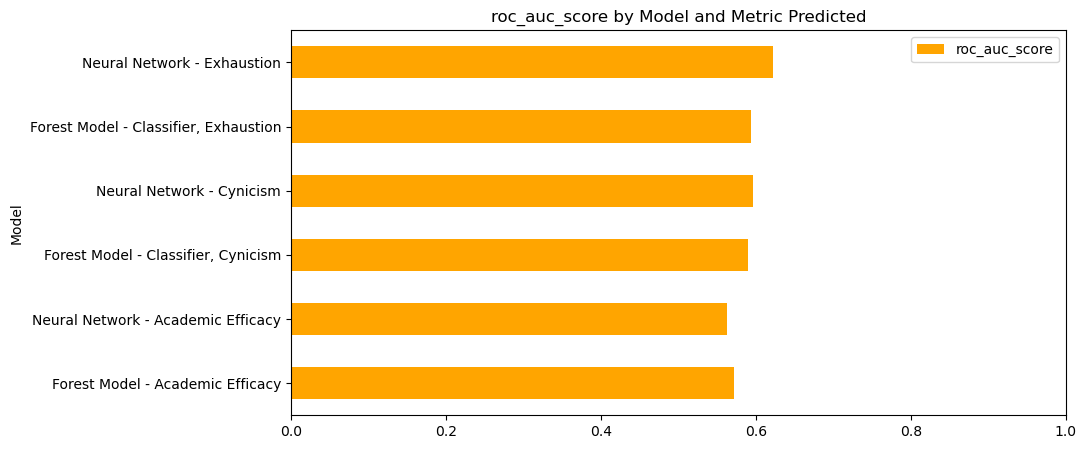

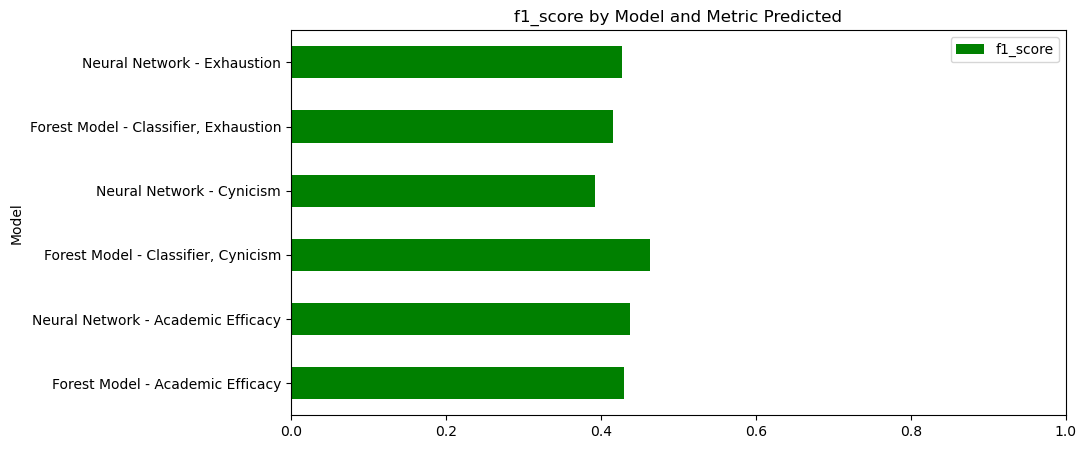

In [43]:
display(results)

#graph results horizontal bar chart, grouped by metric predicted

#order by metric predicted
results = results.sort_values(by=['Metric Predicted'])

results.plot.barh(x='Model', y='Accuracy', figsize=(10, 5), title='Accuracy by Model and Metric Predicted')
results.plot.barh(x='Model', y='roc_auc_score', figsize=(10, 5), title='roc_auc_score by Model and Metric Predicted', color='orange', xlim=(0, 1))
results.plot.barh(x='Model', y='f1_score', figsize=(10, 5), title='f1_score by Model and Metric Predicted', color='green', xlim=(0, 1))
